In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_indices = [i for i, label in enumerate(train_dataset.targets) if label == 0]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label == 0]

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

cuda


In [13]:
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
lr = 0.001
epochs = 50

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Training loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, leave=True)
    for data in loop:
        inputs, _ = data
        inputs = inputs.to(device)
        batch_size = inputs.size(0)

        # Generate noise and real labels
        noise = torch.randn(batch_size, 100).to(device)
        real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs_real = discriminator(inputs)
        loss_real = criterion(outputs_real, real_labels)

        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs_fake = discriminator(fake_images)
        loss_G = criterion(outputs_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Update tqdm loop description with the current losses
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch [1/50]: 100%|██████████| 79/79 [00:02<00:00, 37.29it/s, loss_D=0.334, loss_G=5.82]


Epoch [1/50], Loss D: 0.3342, Loss G: 5.8171


Epoch [2/50]: 100%|██████████| 79/79 [00:02<00:00, 35.68it/s, loss_D=0.332, loss_G=5.25]


Epoch [2/50], Loss D: 0.3315, Loss G: 5.2544


Epoch [3/50]: 100%|██████████| 79/79 [00:02<00:00, 38.31it/s, loss_D=0.345, loss_G=8.46]


Epoch [3/50], Loss D: 0.3451, Loss G: 8.4629


Epoch [4/50]: 100%|██████████| 79/79 [00:02<00:00, 39.19it/s, loss_D=0.333, loss_G=7.71]


Epoch [4/50], Loss D: 0.3331, Loss G: 7.7136


Epoch [5/50]: 100%|██████████| 79/79 [00:02<00:00, 37.83it/s, loss_D=0.33, loss_G=6.53]


Epoch [5/50], Loss D: 0.3299, Loss G: 6.5262


Epoch [6/50]: 100%|██████████| 79/79 [00:02<00:00, 37.27it/s, loss_D=0.339, loss_G=6.2]


Epoch [6/50], Loss D: 0.3389, Loss G: 6.2018


Epoch [7/50]: 100%|██████████| 79/79 [00:02<00:00, 37.79it/s, loss_D=0.34, loss_G=5.4]


Epoch [7/50], Loss D: 0.3397, Loss G: 5.3994


Epoch [8/50]: 100%|██████████| 79/79 [00:02<00:00, 37.30it/s, loss_D=0.372, loss_G=7.26]


Epoch [8/50], Loss D: 0.3716, Loss G: 7.2640


Epoch [9/50]: 100%|██████████| 79/79 [00:02<00:00, 38.85it/s, loss_D=0.47, loss_G=5.35]


Epoch [9/50], Loss D: 0.4698, Loss G: 5.3488


Epoch [10/50]: 100%|██████████| 79/79 [00:02<00:00, 38.45it/s, loss_D=0.396, loss_G=4.27]


Epoch [10/50], Loss D: 0.3959, Loss G: 4.2657


Epoch [11/50]: 100%|██████████| 79/79 [00:02<00:00, 37.97it/s, loss_D=0.429, loss_G=4.76]


Epoch [11/50], Loss D: 0.4294, Loss G: 4.7597


Epoch [12/50]: 100%|██████████| 79/79 [00:02<00:00, 38.77it/s, loss_D=0.46, loss_G=3.95]


Epoch [12/50], Loss D: 0.4604, Loss G: 3.9458


Epoch [13/50]: 100%|██████████| 79/79 [00:02<00:00, 36.31it/s, loss_D=0.419, loss_G=2.51]


Epoch [13/50], Loss D: 0.4188, Loss G: 2.5055


Epoch [14/50]: 100%|██████████| 79/79 [00:02<00:00, 38.03it/s, loss_D=0.587, loss_G=4.08]


Epoch [14/50], Loss D: 0.5873, Loss G: 4.0785


Epoch [15/50]: 100%|██████████| 79/79 [00:02<00:00, 38.37it/s, loss_D=0.408, loss_G=3.5]


Epoch [15/50], Loss D: 0.4078, Loss G: 3.4980


Epoch [16/50]: 100%|██████████| 79/79 [00:02<00:00, 37.42it/s, loss_D=0.46, loss_G=3.8]


Epoch [16/50], Loss D: 0.4601, Loss G: 3.8039


Epoch [17/50]: 100%|██████████| 79/79 [00:02<00:00, 37.81it/s, loss_D=0.535, loss_G=3.5]


Epoch [17/50], Loss D: 0.5353, Loss G: 3.5013


Epoch [18/50]: 100%|██████████| 79/79 [00:02<00:00, 37.96it/s, loss_D=0.485, loss_G=3.59]


Epoch [18/50], Loss D: 0.4850, Loss G: 3.5921


Epoch [19/50]: 100%|██████████| 79/79 [00:02<00:00, 37.24it/s, loss_D=0.837, loss_G=2.67]


Epoch [19/50], Loss D: 0.8370, Loss G: 2.6670


Epoch [20/50]: 100%|██████████| 79/79 [00:02<00:00, 38.43it/s, loss_D=0.566, loss_G=2.81]


Epoch [20/50], Loss D: 0.5662, Loss G: 2.8134


Epoch [21/50]: 100%|██████████| 79/79 [00:02<00:00, 39.02it/s, loss_D=0.57, loss_G=3.03]


Epoch [21/50], Loss D: 0.5703, Loss G: 3.0260


Epoch [22/50]: 100%|██████████| 79/79 [00:02<00:00, 37.43it/s, loss_D=0.497, loss_G=3.8]


Epoch [22/50], Loss D: 0.4966, Loss G: 3.8011


Epoch [23/50]: 100%|██████████| 79/79 [00:02<00:00, 38.90it/s, loss_D=0.471, loss_G=4.44]


Epoch [23/50], Loss D: 0.4714, Loss G: 4.4409


Epoch [24/50]: 100%|██████████| 79/79 [00:02<00:00, 37.78it/s, loss_D=0.856, loss_G=2.23]


Epoch [24/50], Loss D: 0.8557, Loss G: 2.2255


Epoch [25/50]: 100%|██████████| 79/79 [00:02<00:00, 38.11it/s, loss_D=0.435, loss_G=4.81]


Epoch [25/50], Loss D: 0.4345, Loss G: 4.8082


Epoch [26/50]: 100%|██████████| 79/79 [00:02<00:00, 38.34it/s, loss_D=0.438, loss_G=5.06]


Epoch [26/50], Loss D: 0.4381, Loss G: 5.0639


Epoch [27/50]: 100%|██████████| 79/79 [00:02<00:00, 37.69it/s, loss_D=0.609, loss_G=2.79]


Epoch [27/50], Loss D: 0.6087, Loss G: 2.7861


Epoch [28/50]: 100%|██████████| 79/79 [00:02<00:00, 38.43it/s, loss_D=0.564, loss_G=1.99]


Epoch [28/50], Loss D: 0.5639, Loss G: 1.9859


Epoch [29/50]: 100%|██████████| 79/79 [00:02<00:00, 37.74it/s, loss_D=0.686, loss_G=2.86]


Epoch [29/50], Loss D: 0.6856, Loss G: 2.8637


Epoch [30/50]: 100%|██████████| 79/79 [00:02<00:00, 37.56it/s, loss_D=0.6, loss_G=3.06]


Epoch [30/50], Loss D: 0.6004, Loss G: 3.0635


Epoch [31/50]: 100%|██████████| 79/79 [00:02<00:00, 36.70it/s, loss_D=0.427, loss_G=4.83]


Epoch [31/50], Loss D: 0.4267, Loss G: 4.8310


Epoch [32/50]: 100%|██████████| 79/79 [00:02<00:00, 38.79it/s, loss_D=0.362, loss_G=5.95]


Epoch [32/50], Loss D: 0.3617, Loss G: 5.9520


Epoch [33/50]: 100%|██████████| 79/79 [00:02<00:00, 37.60it/s, loss_D=0.514, loss_G=3.89]


Epoch [33/50], Loss D: 0.5142, Loss G: 3.8935


Epoch [34/50]: 100%|██████████| 79/79 [00:02<00:00, 38.47it/s, loss_D=0.661, loss_G=2.52]


Epoch [34/50], Loss D: 0.6606, Loss G: 2.5238


Epoch [35/50]: 100%|██████████| 79/79 [00:02<00:00, 37.18it/s, loss_D=0.57, loss_G=2.91]


Epoch [35/50], Loss D: 0.5700, Loss G: 2.9093


Epoch [36/50]: 100%|██████████| 79/79 [00:02<00:00, 36.97it/s, loss_D=0.606, loss_G=2.7]


Epoch [36/50], Loss D: 0.6057, Loss G: 2.7047


Epoch [37/50]: 100%|██████████| 79/79 [00:02<00:00, 37.19it/s, loss_D=0.535, loss_G=2.85]


Epoch [37/50], Loss D: 0.5347, Loss G: 2.8535


Epoch [38/50]: 100%|██████████| 79/79 [00:02<00:00, 37.76it/s, loss_D=0.498, loss_G=4.41]


Epoch [38/50], Loss D: 0.4980, Loss G: 4.4062


Epoch [39/50]: 100%|██████████| 79/79 [00:02<00:00, 36.73it/s, loss_D=0.489, loss_G=4.15]


Epoch [39/50], Loss D: 0.4894, Loss G: 4.1522


Epoch [40/50]: 100%|██████████| 79/79 [00:02<00:00, 37.30it/s, loss_D=0.433, loss_G=7.68]


Epoch [40/50], Loss D: 0.4332, Loss G: 7.6832


Epoch [41/50]: 100%|██████████| 79/79 [00:02<00:00, 37.20it/s, loss_D=0.465, loss_G=3.43]


Epoch [41/50], Loss D: 0.4647, Loss G: 3.4329


Epoch [42/50]: 100%|██████████| 79/79 [00:02<00:00, 38.79it/s, loss_D=0.406, loss_G=4.46]


Epoch [42/50], Loss D: 0.4058, Loss G: 4.4580


Epoch [43/50]: 100%|██████████| 79/79 [00:02<00:00, 38.49it/s, loss_D=0.467, loss_G=4.49]


Epoch [43/50], Loss D: 0.4675, Loss G: 4.4858


Epoch [44/50]: 100%|██████████| 79/79 [00:02<00:00, 38.90it/s, loss_D=0.686, loss_G=2.82]


Epoch [44/50], Loss D: 0.6864, Loss G: 2.8169


Epoch [45/50]: 100%|██████████| 79/79 [00:02<00:00, 35.26it/s, loss_D=0.72, loss_G=3.4]


Epoch [45/50], Loss D: 0.7195, Loss G: 3.4001


Epoch [46/50]: 100%|██████████| 79/79 [00:02<00:00, 36.76it/s, loss_D=1.15, loss_G=1.38]


Epoch [46/50], Loss D: 1.1496, Loss G: 1.3774


Epoch [47/50]: 100%|██████████| 79/79 [00:02<00:00, 38.59it/s, loss_D=0.551, loss_G=3.41]


Epoch [47/50], Loss D: 0.5511, Loss G: 3.4148


Epoch [48/50]: 100%|██████████| 79/79 [00:02<00:00, 37.77it/s, loss_D=0.552, loss_G=5.24]


Epoch [48/50], Loss D: 0.5516, Loss G: 5.2423


Epoch [49/50]: 100%|██████████| 79/79 [00:02<00:00, 38.16it/s, loss_D=0.442, loss_G=3.83]


Epoch [49/50], Loss D: 0.4416, Loss G: 3.8290


Epoch [50/50]: 100%|██████████| 79/79 [00:02<00:00, 38.52it/s, loss_D=0.718, loss_G=3.55]

Epoch [50/50], Loss D: 0.7176, Loss G: 3.5495


In [14]:
# Function to calculate accuracy
def calculate_accuracy(loader):
    discriminator.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = discriminator(inputs)
            predicted = (outputs > 0.5).float()  # Threshold the outputs to determine if they are real or fake
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    return 100 * correct / total

# Calculate accuracy on the test set
accuracy = calculate_accuracy(test_loader)
print(f"Accuracy on the test set: {accuracy:.2f}%")

Accuracy on the test set: 20.70%


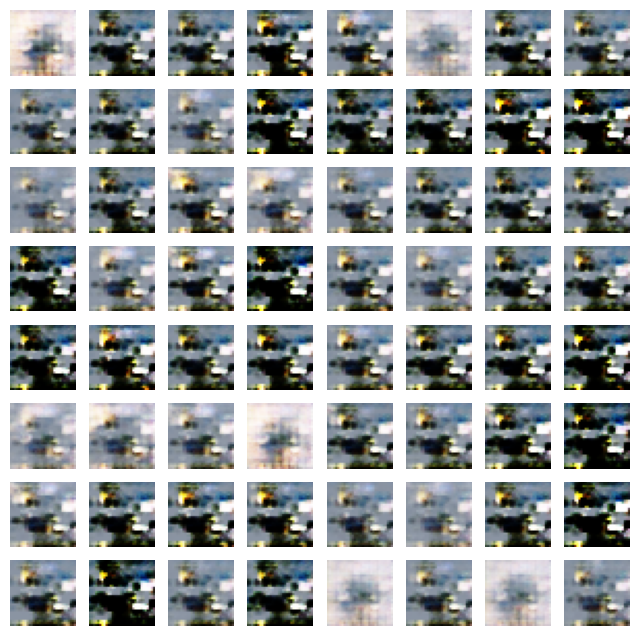

In [15]:
import matplotlib.pyplot as plt

# Generate images
generator.eval()
with torch.no_grad():
    noise = torch.randn(64, 100).to(device)
    generated_images = generator(noise)

# Function to visualize generated images
def show_images(images, num_images=64):
    images = images / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(8, 8, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
    plt.show()

show_images(generated_images)